In [1]:
#!pip install --quiet glvis
import numpy as np
import matplotlib.pyplot as plt
from  bfp import *
import mfem.ser as mfem
#from mfem.common.arg_parser import ArgParser
from glvis import glvis, GlvisData

import os
import h5py

#import math
#import mpi4py.MPI as MPI
#print(MPI.Get_version())

In [2]:
class EnergyDependentCoefficient(mfem.PyCoefficient):
    """Energy-dependent coefficient using either a constant or an array.

    This coefficient maps a normalized energy coordinate (x[1] in [0, 1])
    to a value by linearly interpolating data over an interval defined by E_start and E_end.
    If a constant is provided (e.g., 1), it is converted to an array (with two points)
    and then processed identically to an array input.

    Examples:
        EnergyDependentCoefficient(1)
            # Always returns 1.

        EnergyDependentCoefficient(data_array, E_start=0.0, E_end=1.0)
            # Returns the interpolated value from data_array.
    """

    def __init__(self, data, E_start=None, E_end=None):
        super(EnergyDependentCoefficient, self).__init__()
        if isinstance(data, (int, float)):
            self.constant = True
            self.constant_value = float(data)
        else:
            self.constant = False
            self.data = data
            self.E_start = E_start
            self.E_end = E_end

    def EvalValue(self, ip):
        """Evaluates the coefficient at a given normalized energy coordinate.

        This method converts the normalized energy coordinate (x[1]) to a physical energy
        value, determines the corresponding index (group) in the data array via linear 
        interpolation, and returns the associated coefficient value.

        Args:
            x (list or array-like): A coordinate array where x[1] is the normalized energy 
                (in the range [0, 1]).

        Returns:
            float: The interpolated coefficient value corresponding to the computed energy.
        """
        if self.constant:
            return self.constant_value

        y = ip.y
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.data)
        group = min(n_groups - 1, int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.data[group])


class XDependentCoefficient(mfem.PyCoefficient):
    """X-dependent coefficient using either a constant or a one-dimensional array.

    This coefficient maps a normalized x coordinate (x[0] in [0, 1])
    to a value by linearly interpolating data over an interval defined by x_start and x_end.
    If a constant is provided (e.g., 1), it is converted to an array (with two points)
    and then processed identically to an array input.

    Examples:
        XDependentCoefficient(1)
            # Always returns 1.

        XDependentCoefficient(data_array, x_start=0.0, x_end=1.0)
            # Returns the interpolated value from data_array.
    """

    def __init__(self, data, x_start=None, x_end=None):
        super(XDependentCoefficient, self).__init__()
        if isinstance(data, (int, float)):
            self.constant = True
            self.constant_value = float(data)
        else:
            self.constant = False
            self.data = data
            self.x_start = x_start
            self.x_end = x_end

    def EvalValue(self, ip):
        """Evaluates the coefficient at a given normalized x coordinate.

        This method converts the normalized x coordinate (x[0]) to a physical x
        value, determines the corresponding index (group) in the data array via linear 
        interpolation, and returns the associated coefficient value.

        Args:
            x (list or array-like): A coordinate array where x[0] is the normalized x 
                (in the range [0, 1]).

        Returns:
            float: The interpolated coefficient value corresponding to the computed x.
        """
        if self.constant:
            return self.constant_value

        y = ip.y
        x_val = self.x_start + y * (self.x_end - self.x_start)
        n_groups = len(self.data)
        group = min(n_groups - 1, int((x_val - self.x_start) / (self.x_end - self.x_start) * n_groups))
        return float(self.data[group])
    
class VelocityCoefficient2(mfem.VectorPyCoefficientBase):
    """Velocity vector coefficient for the transport equation.

    Defines a velocity vector:
        v(x) = [μ, S(E)]

    Attributes:
        mu (float): Scalar value, e.g., discrete ordinate.
        S_coef (Coefficient): Coefficient object used to evaluate S(E) at given points.
    """

    def __init__(self, mu, S_coeff):
        mfem.VectorPyCoefficientBase.__init__(self, 2, 0)
        self.mu = mu
        self.S_coeff = S_coeff

    def _EvalPy(self, V, ip):
        """Evaluates the velocity vector at a given integration point.

        Args:
            V (array_like): Output vector of size 2 to store the velocity.
            ip (IntegrationPoint): Integration point where the evaluation occurs.
        """
        V[0] = self.mu
        V[1] = self.S_coeff.EvalValue(ip)
        return V
    
def set_inflow_boundary_attribute(mesh, x_start, E_start, tol=1e-6):
    """
    Sets the inflow boundary attribute for mesh elements that contain a vertex at (x_start, E_start).
    All other boundary elements are set to attribute 0.

    Parameters:
        mesh (mfem.Mesh): The mesh object.
        x_start (float): The x-coordinate for the inflow boundary.
        E_start (float): The energy coordinate for the inflow boundary.
        tol (float): Tolerance for comparing coordinates.
    """
    vertex_array = mesh.GetVertexArray()

    # Set all boundary element attributes to 0 initially
    for i in range(mesh.GetNBE()):
        mesh.SetBdrAttribute(i, 0)

    # For each boundary element, check all vertices
    for i in range(mesh.GetNBE()):
        v_indices = mesh.GetBdrElementVertices(i)
        for idx in v_indices:
            vx = vertex_array[idx][0]
            vE = vertex_array[idx][1]
            if abs(vx - x_start) < tol and abs(vE - E_start) < tol:
                mesh.SetBdrAttribute(i, 1)
                break
    """
    # Optional: Print out boundary elements for verification
    for i in range(mesh.GetNBE()):
        v_indices = mesh.GetBdrElementVertices(i)
        idx0 = v_indices[0]
        vx = vertex_array[idx0][0]
        vE = vertex_array[idx0][1]
        attr = mesh.GetBdrAttribute(i)
        print(f"Boundary element {i}: Vertex = ({vx}, {vE}), Attribute = {attr}")"
        """

File '/Users/melekderman/github/BFP/examples1/mesh/usr/20x50_2D.mesh' already exists.
Number of unknowns: 4000
  Solving for mu = -0.9602898564975362
ip.y = 1.00 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.90 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.80 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.70 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.60 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.51 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.41 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.31 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.21 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.11 için vektör: [-0.9602898564975362, 20.0]
ip.y = 0.01 için vektör: [-0.9602898564975362, 20.0]
    GMRES (mu = -0.9602898564975362 ): iterations = 1 final norm = 5.2100768673682586e-12
  Solving for mu = -0.7966664774136267
ip.y = 1.00 için vektör: [-0.7966664774136267, 20.0]
ip.y = 0.90 için vektör: [-0.7966664774136267, 20.0]
ip.y = 0.80 için vektör: [-0.796

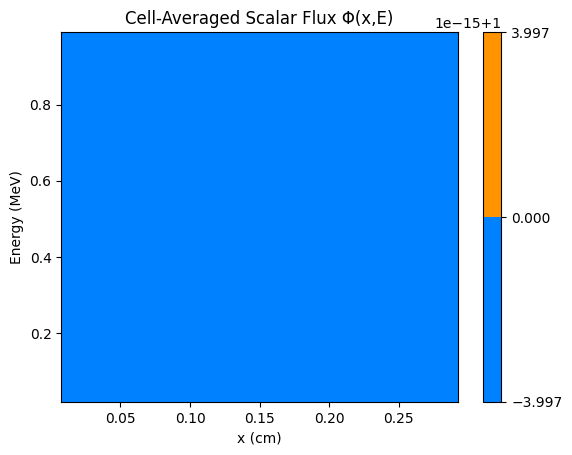

In [4]:
# Set parameters
nx = 20         
nE = 50         
x_start = 0.0
x_end = 0.3
E_start = 1
E_end = 0.01
N_ang = 8       
order = 1

mfem.IntegrationPoint()
"""
r_bound = 0.0
l_bound = 1.0
l_bound_coeff = mfem.ConstantCoefficient(l_bound)
r_bound_coeff = mfem.ConstantCoefficient(r_bound)
r_marker1 = mfem.intArray([1])
r_marker2 = mfem.intArray([4])
l_marker1 = mfem.intArray([2])
l_marker2 = mfem.intArray([3])


matCoef = mfem.ConstantCoefficient(1.0)
constant_factor = 1
h_x = (x_start - x_end) / nx
h_E = (E_start - E_end) / nE
h = np.average([h_x, h_E])
sigma = constant_factor * (order**2) / h
kappa = 0.3
"""

# Create mesh and finite element space
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()
set_inflow_boundary_attribute(mesh, x_start, E_start, 1e-8)
fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetTrueVSize()
print("Number of unknowns:", Size)

# Gauss-Legendre angular quadrature points and weights
mu_vals, w_vals = gauss_legendre_dirs(N_ang)
zeroCoeff = mfem.ConstantCoefficient(0.0)

# Read data and define material coefficients
E_arr, E_grid_arr, xs_t_arr, xs_s_arr, neg_S_arr = read_data(50)
S_arr = - neg_S_arr
dS_dE_arr = compute_S_derivative(E_arr, S_arr) 
xs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)
xs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)
S_coeff    = EnergyDependentCoefficient(20)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(dS_dE_arr, E_start, E_end)

phi = mfem.GridFunction(fes)
phi.Assign(1.0)

psi_mu_list = []

# Angular sweep
for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)
    mu_coeff = XDependentCoefficient(mu)
    # Create the velocity coefficient based on mu and S(E)
    v_coeff = VelocityCoefficient2(mu, S_coeff)


    for y_norm in np.linspace(1, 0.01, 11):
        ip = mfem.IntegrationPoint()
        ip.x = 0.3
        ip.y = 0.7
        V = mfem.Vector(2)
        v_coeff._EvalPy(V, ip)
        values = [V[i] for i in range(V.Size())]
        print(f"ip.y = {y_norm:0.2f} için vektör: {values}")


    # Set up the DG bilinear form A(.,.)
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, 1.0))) 
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, 1.0)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()
    
    # Set up the linear form b for the RHS
    b = mfem.LinearForm(fes)
    q_coeff = mfem.ConstantCoefficient(0.0)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    #scattering_source = mfem.ProductCoefficient(xs_s_coeff, mfem.GridFunctionCoefficient(phi))
    inflow_val = mfem.ConstantCoefficient(1.0)
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_val, v_coeff, -1.0, -1.0))
    #b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(r_bound_coeff, matCoef, sigma, kappa), r_marker1)
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(l_bound_coeff, matCoef, sigma, kappa), l_marker1)
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(r_bound_coeff, matCoef, sigma, kappa), r_marker2)
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(l_bound_coeff, matCoef, sigma, kappa), l_marker2)
    b.Assemble()
    
    
    #ess_bdr = mfem.intArray(mesh.bdr_attributes.Max())
    #ess_bdr[4] = 1
    #boundary_dofs = mfem.intArray()
    #fes.GetBoundaryDofs(ess_bdr, boundary_dofs)

    # Solve the system A * psi = b using MFEM's internal GMRES solver
    psi = mfem.GridFunction(fes)
    psi.Assign(1.0)  # initial guess
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)
    print("    GMRES (mu =", mu, "): iterations =", solver.GetNumIterations(),
          "final norm =", solver.GetFinalNorm())
    
    psi_copy = psi
    psi_mu_list.append((mu, w, psi_copy))

    psi.Save("psi_mu_{:.3f}.gf".format(mu))



# Combine angular solutions to compute the scalar flux:
phi_new = mfem.GridFunction(fes)
phi_new.Assign(0.0)
for mu, w, psi in psi_mu_list:
    phi_new.Add(w, psi)

glvis((mesh, phi))
# Save the final scalar flux φ to file.
phi_new.Save("phi_new.gf")
print("\nScalar flux saved to file: phi.gf")

#Plot the data using matplotlib
# Convert phi and mesh data into numpy arrays for plotting.
phi_arr = np.array([phi_new[i] for i in range(phi_new.Size())])
# Get nodal coordinates from the mesh.
nodal_coords = np.array([[mesh.GetVertexArray()[i][0], mesh.GetVertexArray()[i][1]]
                           for i in range(mesh.GetNV())])

# Cell-averaged flux values
num_cells = mesh.GetNE()
cell_avg_2d = np.zeros((nE, nx))

# Elements are ordered row-major:
cell_counter = 0
for iE in range(nE):
    for ix in range(nx):
        # Get the list of DOF indices for the current element.
        dof_indices = fes.GetElementVDofs(cell_counter)
        # Compute the average value of phi over this cell.
        vals = [phi[i] for i in dof_indices]
        cell_avg_2d[iE, ix] = np.mean(vals)
        cell_counter += 1

# For x
x_nodes = np.linspace(x_start, x_end, nx+1)
cell_x = 0.5 * (x_nodes[:-1] + x_nodes[1:])  

# For energy
E_nodes = np.linspace(E_start, E_end, nE+1)
cell_E = 0.5 * (E_nodes[:-1] + E_nodes[1:])

# Create a 2D meshgrid from the cell centers:
X, E_mesh = np.meshgrid(cell_x, cell_E)

# Plot the cell-averaged scalar flux.
plt.figure()
cp = plt.contourf(X, E_mesh, cell_avg_2d, levels=50, cmap='jet')
plt.colorbar(cp)
plt.xlabel("x (cm)")
plt.ylabel("Energy (MeV)")
plt.title("Cell-Averaged Scalar Flux Φ(x,E)")
plt.show()


In [205]:


for x in np.linspace(0, 1, 10):
    ip = mfem.IntegrationPoint()
    ip.x = x
    ip.y = 0.0
    V = mfem.Vector(2)
    v_coef._EvalPy(V, ip)
# Vektördeki değerleri listeye dönüştürmek:
values = [V[i] for i in range(V.Size())]
print("Değerler:", values)



TypeError: in method 'VectorPyCoefficientBase__EvalPy', argument 3 of type 'mfem::Vector &'

In [206]:
xs_t_coeff

<bfp.coeff.TotalXSCoefficient; proxy of <Swig Object of type '_p_mfem__PyCoefficientBase' at 0x1687b60a0> >

In [207]:

velo_coeff = VelocityCoefficient(mu_vals[0], S_coeff)
velo_coeff



<bfp.coeff.VelocityCoefficient; proxy of <Swig Object of type '_p_mfem__VectorPyCoefficientBase' at 0x16964c6c0> >

In [6]:
mesh.GetBdrAttributeArray()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [7]:
glvis((mesh, phi), 900, 900)

_GlvisWidgetCore(data_str='solution\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POIN…

In [8]:
import numpy as np
import mfem.ser as mfem

def build_element_map(mesh, nx, ny, x_start, x_end, y_start, y_end):

    element_map = {}
    cell_width = (x_end - x_start) / nx
    cell_height = (y_start - y_end) / ny  
    
    for e in range(mesh.GetNE()):
        vtx_ids = mesh.GetElementVertices(e) 
        
        coords = []
        for vid in vtx_ids:
            vertex = mesh.GetVertexArray()[vid]
            coords.append((vertex[0], vertex[1]))
        
        avg_x = np.mean([c[0] for c in coords])
        avg_y = np.mean([c[1] for c in coords])
        ix = int((avg_x - x_start) / cell_width)
        iE = int((y_start - avg_y) / cell_height)
        element_map[e] = (iE, ix)
    
    return element_map

element_map = build_element_map(mesh, nx, nE, x_start, x_end, E_start, E_end)

for e in range(5):
    print("Element", e, "-> (Energy index, x index):", element_map[e])


Element 0 -> (Energy index, x index): (0, 0)
Element 1 -> (Energy index, x index): (1, 0)
Element 2 -> (Energy index, x index): (2, 0)
Element 3 -> (Energy index, x index): (2, 1)
Element 4 -> (Energy index, x index): (1, 1)


In [9]:
mesh5 = mfem.Mesh(nx, nE, "QUADRILATERAL", True, 0.3, 0.99)
mesh5.Print("meshbes.mesh")
glvis(mesh5)

_GlvisWidgetCore(data_str='mesh\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POINT   …

In [10]:
'''
# This will be the init function:
nx = 20
nE = 50
x_start = 0.0
x_end = 0.3
E_start = 1.0
E_end = 0.01
N_ang = 8
order = 1


#mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
#dim = mesh.Dimension()

#fec = mfem.DG_FECollection(order, dim)
#fes = mfem.FiniteElementSpace(mesh, fec)

#ndofs = fes.GetVSize()
#print(f"Number of dimensions: {dim}")
#print(f"Number of finite element unknowns: {ndofs}")

#a = mfem.BilinearForm(fes)

#ess_tdof_list = mfem.intArray()
#dir_bdr = mfem.intArray(mesh.bdr_attributes.Max())
#dir_bdr.Assign(1)
#dir_bdr.Size()

#print(f"Number of finite element dir_bdr.Size(): {dir_bdr.Size()}")
#print(f"Number of finite element ess_tdof_list.Size(): {ess_tdof_list.Size()}")

#inflow_coeff = Inflow2DCoefficient(1.0)

# Read cross-section and stopping power data and compute necessary coefficients
E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr = read_data(50)
dS_dE_arr = compute_S_derivative(E_arr, -S_arr)
xs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)
xs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)
S_coeff = StoppingPowerCoefficient(-S_arr, E_start, E_end)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(dS_dE_arr, E_start, E_end)

# Get Gauss-Legendre angular quadrature points and weights
mu_vals, w_vals = gauss_legendre_dirs(N_ang)

# Create a 2D mesh and finite element space (this remains fixed for all iterations)
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
#transformer = MeshTransformer2D(x_start, x_end, E_start, E_end)
#transformer.Transform(mesh)
dim = mesh.Dimension()
fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
print("Number of unknowns:", fes.GetTrueVSize())

# Initialize the total solution phi (scattering source) to 1 everywhere.
phi = mfem.GridFunction(fes)
phi.Assign(1.0)

# Source iteration parameters
max_iter = 20
tol = 1e-6

# Start the source iteration loop
for iter in range(max_iter):
    print("Source iteration, iter =", iter)
    psi_mu_list = []  # To store tuples (mu, weight, psi) for each angular direction

    # Angular sweep: solve for each angular direction μ
    for mu, w in zip(mu_vals, w_vals):
        print("  Solving for μ =", mu)
        # Define the velocity coefficient v_coef depending on μ and S(E)
        v_coef = VelocityCoefficient(mu, S_coeff)

        # Set up the DG bilinear form a(.,.) on the fixed FE space.
        # The integrators include:
        # - A ConvectionIntegrator for the term: μ∂ψ/∂x + S(E)∂ψ/∂E
        # - Two MassIntegrators for the reaction term: [S'(E) + Σₜ(E)] ψ and for material interaction
        # - Face integrators for interior and boundary faces via NonconservativeDGTraceIntegrator.
        a = mfem.BilinearForm(fes)
        a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
        a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
        a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
        a.AddInteriorFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.AddBdrFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.Assemble()
        a.Finalize()

        # Set up the linear form b(·) for the right-hand side.
        # Here, we add the boundary inflow condition and a scattering source term.
        b = mfem.LinearForm(fes)
        inflow_2d = Inflow2DCoefficient(1.0)
        b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_2d, v_coef, 1.0))
        # Add scattering source: xs_s_coeff * φ (current source iterate)
        scattering_source = mfem.ProductCoefficient(xs_s_coeff, mfem.GridFunctionCoefficient(phi))
        b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
        b.Assemble()

        # Solve the linear system Aψ = b using GMRES.
        A = a.SpMat()
        prec = mfem.GSSmoother(A)
        solver = mfem.GMRESSolver()
        solver.SetOperator(A)
        solver.SetPreconditioner(prec)
        solver.SetRelTol(1e-12)
        solver.SetAbsTol(1e-12)
        solver.SetMaxIter(500)
        solver.SetKDim(30)
        solver.SetPrintLevel(0)

        # Initialize the angular solution ψ for this μ.
        psi = mfem.GridFunction(fes)
        psi.Assign(1.0)
        solver.Mult(b, psi)
        print("    GMRES iterations (μ = {}):".format(mu), solver.GetNumIterations(), " final norm:", solver.GetFinalNorm())
        psi_mu_list.append((mu, w, psi))

    # Angular integration: compute the updated total solution φ_new(x,E) = Σ_μ w(μ) ψ(x,E,μ)
    phi_new = mfem.GridFunction(fes)
    phi_new.Assign(0.0)
    for mu, w, psi in psi_mu_list:
        phi_new.Add(w, psi)

    # Check convergence of the source iteration by computing the L2 norm of (phi_new - phi)
    diff_gf = mfem.GridFunction(fes)
    diff_gf.Assign(phi_new)
    diff_gf.Add(-1.0, phi)
    diff = diff_gf.Norml2()

    print("  Source iteration diff =", diff)
    if diff < tol:
        phi.Assign(phi_new)
        print("Source iteration converged.")
        break
    phi.Assign(phi_new)                
'''




'''
for mu, w in zip(mu_vals, w_vals):
    print("Solving for μ =", mu)
    # Create a 2D mesh over [0,L] x [E_min,E_max] using quadrilaterals.
    mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
    #transformer = MeshTransformer2D(x_start, x_end, E_start, E_end)
    #transformer.Transform(mesh)
    dim = mesh.Dimension()
    order = 2

    # Define the DG finite element space using L2 elements
    fec = mfem.L2_FECollection(order, dim)
    fes = mfem.FiniteElementSpace(mesh, fec)
    print("Number of unknowns:", fes.GetTrueVSize())
    v_coef = VelocityCoefficient(mu, S_coeff)

    # Set up the bilinear form a(.,.) for the DG formulation.
    a = mfem.BilinearForm(fes)
    # Volume integrator for convection term: μ ∂ψ/∂x + S(E) ∂ψ/∂E.
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
    # Mass integrators for the reaction term: [S'(E) + Σₜ(E)] ψ.
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddInteriorFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
    a.AddBdrFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
    a.Assemble()
    a.Finalize()
    
    b = mfem.LinearForm(fes)
    inflow_2d = Inflow2DCoefficient(1.0)
    q_coef = QCoefficient(0)
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_2d, v_coef, 1.0))
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coef))
    b.Assemble()

    # Solve the linear system using GMRES
    A = a.SpMat()
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(1)

    # Initialize the solution GridFunction
    psi = mfem.GridFunction(fes)
    psi.Assign(1.0)
    solver.Mult(b, psi)
    print("GMRES iterations (μ = {}):".format(mu), solver.GetNumIterations(), " final norm:", solver.GetFinalNorm())
    # Save the solution for this angular direction and store in list
    psi_mu_list.append((mu, psi))
    out_name = f"psi_mu_{mu:.3f}.gf"
    psi.Save(out_name)
    print(f"Solution for μ = {mu:.3f} saved to {out_name}.\n")

    
# Angular integration: compute total solution phi(x,E) = Σ_{μ} w(μ) ψ(x,E,μ)

phi = mfem.GridFunction(fes)
phi.Assign(0.0)
for mu, psi in psi_mu_list:
    weight = w_vals[mu_vals.index(mu)]
    phi.Add(weight, psi)
out_total = "phi.gf"
phi.Save(out_total)
print("Angle-integrated solution saved to", out_total)
# Save the mesh for GLVis visualization
mesh.Print("mesh.mesh")
print("Mesh saved to mesh.mesh")


#---------------------------------------------------
# GLVis Visualization
#---------------------------------------------------
# Visualize the total (angle-integrated) solution with GLVis.
# The title is set to "Total Angular Flux" and we wait for 500 ms.
glvis(mesh, phi, "Total Angular Flux", 500)
#---------------------------------------------------
# Dose Calculation and Plotting (Matplotlib)
#---------------------------------------------------
# Here, we compute the average flux in the energy (y) direction for each x cell,
# then define dose as the normalized flux relative to the value at x=0.
x_coords = []
avg_flux = []
for i in range(nx):
    # x coordinate of the cell center
    x_val = x_start + (x_end - x_start)*(i + 0.5)/ nx
    cell_vals = []
    for j in range(ny):
        # y (energy) coordinate of the cell center
        y_val = E_start + (E_end - E_start)*(j + 0.5) / nE
        # Compute cell index in row-major order
        cell_index = i * nE + j
        cell_vals.append(phi[cell_index])
    x_coords.append(x_val)
    avg_flux.append(np.mean(cell_vals))
avg_flux = np.array(avg_flux)
# Define dose as the normalized average flux (dose at x divided by dose at x=0)
dose = avg_flux / avg_flux[0]
# Plot the average flux along x
plt.figure()
plt.plot(x_coords, avg_flux, 'o-', label='Average Flux')
plt.xlabel("x (cm)")
plt.ylabel("Average Angular Flux ψ(x)")
plt.title("Average Angular Flux vs. x")
plt.grid(True)
plt.legend()
# Plot the computed dose profile
plt.figure()
plt.plot(x_coords, dose, 's-', color='red', label='Dose (Normalized)')
plt.xlabel("x (cm)")
plt.ylabel("Dose (normalized)")
plt.title("Dose Profile vs. x")
plt.grid(True)
plt.legend()
plt.show()


'''


'\nfor mu, w in zip(mu_vals, w_vals):\n    print("Solving for μ =", mu)\n    # Create a 2D mesh over [0,L] x [E_min,E_max] using quadrilaterals.\n    mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)\n    #transformer = MeshTransformer2D(x_start, x_end, E_start, E_end)\n    #transformer.Transform(mesh)\n    dim = mesh.Dimension()\n    order = 2\n\n    # Define the DG finite element space using L2 elements\n    fec = mfem.L2_FECollection(order, dim)\n    fes = mfem.FiniteElementSpace(mesh, fec)\n    print("Number of unknowns:", fes.GetTrueVSize())\n    v_coef = VelocityCoefficient(mu, S_coeff)\n\n    # Set up the bilinear form a(.,.) for the DG formulation.\n    a = mfem.BilinearForm(fes)\n    # Volume integrator for convection term: μ ∂ψ/∂x + S(E) ∂ψ/∂E.\n    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))\n    # Mass integrators for the reaction term: [S\'(E) + Σₜ(E)] ψ.\n    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))\n    a.AddDomainIntegrator(mfem.M

In [11]:
def create_3D_mesh(nx, ny, nz, x_start, x_end, y_start, y_end, z_start, z_end):
    """
    Creates a 3D mesh with specified intervals and coordinate ranges.

    Args:
        nx (int): Number of intervals in the x-direction.
        ny (int): Number of intervals in the y-direction.
        nz (int): Number of intervals in the z-direction.
        x_start (float): Starting x-coordinate.
        x_end (float): Ending x-coordinate.
        y_start (float): Starting y-coordinate.
        y_end (float): Ending y-coordinate.
        z_start (float): Starting z-coordinate.
        z_end (float): Ending z-coordinate.

    Returns:
        mesh: The updated 3D mesh with vertex coordinates set accordingly.
    """
    # Generate equally spaced coordinates for x, y, and z
    x_coords = np.linspace(x_start, x_end, nx + 1)
    y_coords = np.linspace(y_start, y_end, ny + 1)
    z_coords = np.linspace(z_start, z_end, nz + 1)
    
    # Create the 3D mesh with initial x, y, z values set to 0
    mesh = mfem.Mesh(nx, ny, nz, "HEXAHEDRON", True, 0.0, 0.0, 0.0)
    
    # Retrieve the vertex array from the mesh
    verts = mesh.GetVertexArray()
    
    # Expected number of vertices: (nx+1) * (ny+1) * (nz+1)
    expected_num = (nx + 1) * (ny + 1) * (nz + 1)
    num_verts = mesh.GetNV()
    if num_verts != expected_num:
        print("Warning: Unexpected number of vertices! ({} != {})".format(num_verts, expected_num))
    
    # Update the vertex coordinates; vertices are stored in order: x changes fastest, then y, then z.
    k = 0
    for k_z in range(nz + 1):
        for k_y in range(ny + 1):
            for k_x in range(nx + 1):
                verts[k][0] = x_coords[k_x]
                verts[k][1] = y_coords[k_y]
                verts[k][2] = z_coords[k_z]
                k += 1
    
    # Define the target directory and file name
    target_dir = os.path.join(os.getcwd(), 'mesh', 'usr')
    file_name = f'{nx}x{ny}_3D.mesh'
    file_path = os.path.join(target_dir, file_name)
    
    # Check if the target directory exists; if not, create it
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Directory '{target_dir}' was created.")

    # Check if the file already exists
    if not os.path.exists(file_path):
        # If the file does not exist, write the mesh to the file
        mesh.Print(file_path)
        print(f"File '{file_path}' was successfully created.")
    else:
        print(f"File '{file_path}' already exists.")

    return mesh

In [12]:
glvis(mesh, 900, 900)

_GlvisWidgetCore(data_str='mesh\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POINT   …

In [13]:
mesh1 = create_3D_mesh(20, 20, 50, 0, 1, 0, 1, 1, 0.01)
glvis(mesh1, 900, 900)

File '/Users/melekderman/github/BFP/examples1/mesh/usr/20x20_3D.mesh' already exists.


_GlvisWidgetCore(data_str='mesh\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POINT   …

In [ ]:
'''# Initialize parameters
nx = 20         
nE = 50         
x_start = 0.0
x_end = 0.3
E_start = 1.0
E_end = 0.01
N_ang = 8       
order = 1

'''# Infinite medium problem coefficients
dS_dE_coeff = np.zeros(nE)
S_coeff = np.zeros(nE)
inflow_coeff = InflowCoefficient(2.0)
xs_t_arr = np.ones(nE) * 2
xs_s_arr = np.zeros(nE)
S_arr = np.zeros(nE)
q_arr = np.ones(nE) * 8
'''
# Get Gauss-Legendre angular quadrature points and weights
mu_vals, w_vals = gauss_legendre_dirs(N_ang)

# Read cross-section and stopping power data, then compute necessary coefficients
E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr = read_data(50)
dS_dE_arr = compute_S_derivative(E_arr, S_arr)
xs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)
xs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)
S_coeff = StoppingPowerCoefficient(S_arr, E_start, E_end)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(dS_dE_arr, E_start, E_end)

# Create a 2D mesh and finite element space (this remains fixed for all iterations)
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()
fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
print("Number of unknowns:", fes.GetTrueVSize())

# Project each coefficient onto the finite element space and save as grid functions.
gf_xs_t = mfem.GridFunction(fes)
gf_xs_t.ProjectCoefficient(xs_t_coeff)
gf_xs_t.Save("xs_t_coeff.gf")
print("Total cross-section coefficient saved to xs_t_coeff.gf")

gf_xs_s = mfem.GridFunction(fes)
gf_xs_s.ProjectCoefficient(xs_s_coeff)
gf_xs_s.Save("xs_s_coeff.gf")
print("Scattering cross-section coefficient saved to xs_s_coeff.gf")

gf_S = mfem.GridFunction(fes)
gf_S.ProjectCoefficient(S_coeff)
gf_S.Save("S_coeff.gf")
print("Stopping power coefficient saved to S_coeff.gf")

# Initialize the total solution (scattering source) phi to 1 everywhere.
phi = mfem.GridFunction(fes)
phi.Assign(1.0)

# Source iteration parameters
max_iter = 20
tol = 1e-6

# Start the source iteration loop
for iter in range(max_iter):
    print("Source iteration, iter =", iter)
    psi_mu_list = []  # To store tuples (mu, weight, psi) for each angular direction

    # Angular sweep: solve for each angular direction μ
    for mu, w in zip(mu_vals, w_vals):
        print("  Solving for μ =", mu)
        # Define the velocity coefficient based on μ and S(E)
        v_coef = VelocityCoefficient(mu, S_coeff)

        # Set up the DG bilinear form a(.,.) on the fixed FE space.
        # The integrators include:
        # - ConvectionIntegrator for the term: μ∂ψ/∂x + S(E)∂ψ/∂E
        # - MassIntegrators for the reaction term: [S'(E) + Σₜ(E)]ψ and for material interaction
        # - NonconservativeDGTraceIntegrator for interior and boundary faces.
        a = mfem.BilinearForm(fes)
        a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
        a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
        a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
        a.AddInteriorFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.AddBdrFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.Assemble()
        a.Finalize()

        # Set up the linear form b(·) for the right-hand side.
        # Add the boundary inflow condition and the scattering source term.
        b = mfem.LinearForm(fes)
        inflow_2d = Inflow2DCoefficient(1.0)
        b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_2d, v_coef, 1.0))
        scattering_source = mfem.ProductCoefficient(xs_s_coeff, mfem.GridFunctionCoefficient(phi))
        b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
        b.Assemble()

        # Solve the linear system A ψ = b using GMRES.
        A = a.SpMat()
        prec = mfem.GSSmoother(A)
        solver = mfem.GMRESSolver()
        solver.SetOperator(A)
        solver.SetPreconditioner(prec)
        solver.SetRelTol(1e-12)
        solver.SetAbsTol(1e-12)
        solver.SetMaxIter(500)
        solver.SetKDim(30)
        solver.SetPrintLevel(0)

        # Initialize the angular solution ψ for this μ.
        psi = mfem.GridFunction(fes)
        psi.Assign(1.0)
        solver.Mult(b, psi)
        print("    GMRES iterations (μ = {}):".format(mu),
              solver.GetNumIterations(), "final norm:", solver.GetFinalNorm())

        # Append the result to the list (for each discrete ordinate)
        psi_copy = mfem.GridFunction(fes)
        psi_copy.Assign(psi)
        psi_mu_list.append((mu, w, psi_copy))


        # Optional: Save each angular solution and corresponding mesh to separate files
        psi.Save("psi_mu_{:.3f}.gf".format(mu))
        mesh.Save("mesh_mu_{:.3f}.mesh".format(mu))

        # --- Combining the Results ---
        # Compute the scalar (angle-integrated) flux: ψ(x,E) = Σ_μ (w_μ * ψ_μ(x,E))
        psi_copy = mfem.GridFunction(fes)
        psi_copy.Assign(psi)
        psi_mu_list.append((mu, w, psi_copy))
    
        psi_copy.Assign(0.0)
        for (mu, w, psi_mu) in psi_mu_list:
            psi_copy.Add(w, psi_mu)
        psi_copy.Save("psi_scalar.gf")
        print("Scalar flux saved to file: psi_scalar.gf")
    
        # Update the total solution φ: φ_new(x,E) = Σ_μ w(μ) ψ(x,E,μ)
        phi_new = mfem.GridFunction(fes)
        phi_new.Assign(0.0)
        for mu, w, psi in psi_mu_list:
            phi_new.Add(w, psi)
    
        # Check convergence of the source iteration by computing the L2 norm of (φ_new - φ)
        diff_gf = mfem.GridFunction(fes)
        diff_gf.Assign(phi_new)
        diff_gf.Add(-1.0, phi)
        diff = diff_gf.Norml2()
        print("  Source iteration diff =", diff)
        if diff < tol:
            phi.Assign(phi_new)
            print("phi_new =", phi)
        print("Source iteration converged at iter =", iter)
        phi.Assign(phi_new)
'''

NameError: name 'Inflow2DCoefficient' is not defined

In [15]:
class VelocityCoefficient(mfem.VectorPyCoefficientBase):
    """Velocity vector coefficient for the transport equation.

    Defines a velocity vector:
        v(x) = [μ, S(E)]

    Attributes:
        mu (float): Scalar value, e.g., discrete ordinate.
        S_coef (Coefficient): Coefficient object used to evaluate S(E) at given points.
    """

    def __init__(self, mu, S_coef):
        mfem.VectorPyCoefficientBase.__init__(self, 2, 0)
        self.mu = mu
        self.S_coef = S_coef

    def _EvalPy(self, V, ip):
        """Evaluates the velocity vector at a given integration point.

        Args:
            V (array_like): Output vector of size 2 to store the velocity.
            ip (IntegrationPoint): Integration point where the evaluation occurs.
        """
        V[0] = self.mu
        V[1] = self.S_coef.EvalValue(ip)


In [16]:
vel = VelocityCoefficient(mu_vals, S_coeff)

Number of unknowns: 9000
  Solving for mu = -0.9602898564975362
    GMRES (mu = -0.9602898564975362 ): iterations = 1 final norm = 4.3085998470343456e-13
  Solving for mu = -0.7966664774136267
    GMRES (mu = -0.7966664774136267 ): iterations = 1 final norm = 4.3085998470343456e-13
  Solving for mu = -0.525532409916329
    GMRES (mu = -0.525532409916329 ): iterations = 1 final norm = 4.3085998470343456e-13
  Solving for mu = -0.1834346424956498
    GMRES (mu = -0.1834346424956498 ): iterations = 1 final norm = 4.3085998470343456e-13
  Solving for mu = 0.1834346424956498
    GMRES (mu = 0.1834346424956498 ): iterations = 1 final norm = 4.3085998470343456e-13
  Solving for mu = 0.525532409916329
    GMRES (mu = 0.525532409916329 ): iterations = 1 final norm = 4.3085998470343456e-13
  Solving for mu = 0.7966664774136267
    GMRES (mu = 0.7966664774136267 ): iterations = 1 final norm = 4.3085998470343456e-13
  Solving for mu = 0.9602898564975362
    GMRES (mu = 0.9602898564975362 ): iterat

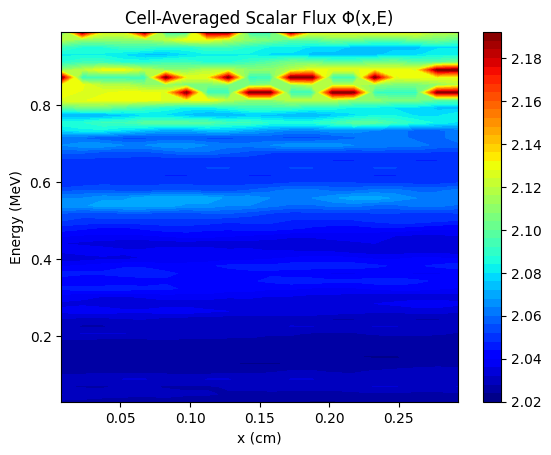

In [24]:
order = 2
r_bound = 0.0
l_bound = 1.0
l_bound_coeff = mfem.ConstantCoefficient(l_bound)
r_bound_coeff = mfem.ConstantCoefficient(r_bound)
r_marker1 = mfem.intArray([1])
r_marker2 = mfem.intArray([4])
l_marker1 = mfem.intArray([2])
l_marker2 = mfem.intArray([3])


matCoef = mfem.ConstantCoefficient(1.0)
constant_factor = 1
h_x = (x_start - x_end) / nx
h_E = (E_start - E_end) / nE
h = np.average([h_x, h_E])
sigma = constant_factor * (order**2) / h
kappa = 0.3


# Create mesh and finite element space
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()

fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetTrueVSize()
print("Number of unknowns:", Size)

# Gauss-Legendre angular quadrature points and weights
mu_vals, w_vals = gauss_legendre_dirs(N_ang)

zeroCoeff = mfem.ConstantCoefficient(0.0)
# Read data and define material coefficients
E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr = read_data(50)
dS_dE_arr = compute_S_derivative(E_arr, S_arr) 
xs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)
xs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)
S_coeff    = StoppingPowerCoefficient(S_arr, E_start, E_end)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(dS_dE_arr, E_start, E_end)


# Set the initial scalar flux
phi = mfem.GridFunction(fes)
phi.Assign(1.0)

# Source iteration parameters
max_iter = 50
tol = 1e-6
relax = 0.7


psi_mu_list = []

# Angular sweep
for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)

    # Create the velocity coefficient based on mu and S(E)
    v_coef = VelocityCoefficient(mu, S_coeff)
    
    # Set up the DG bilinear form A(.,.)
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coef, 1.0, -0.5))) 
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coef, 1.0, -0.5)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()
    
    # Set up the linear form b for the RHS
    b = mfem.LinearForm(fes)
    q_coeff = mfem.ConstantCoefficient(0.0)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    scattering_source = mfem.ProductCoefficient(xs_s_coeff, mfem.GridFunctionCoefficient(phi))
    inflow_val = mfem.ConstantCoefficient(1.0)
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_val, v_coef, -1.0, -0.5))
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(r_bound_coeff, matCoef, sigma, kappa), r_marker1)
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(l_bound_coeff, matCoef, sigma, kappa), l_marker1)
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(r_bound_coeff, matCoef, sigma, kappa), r_marker2)
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(l_bound_coeff, matCoef, sigma, kappa), l_marker2)
    b.Assemble()
    
    
    #ess_bdr = mfem.intArray(mesh.bdr_attributes.Max())
    #ess_bdr[4] = 1
    #boundary_dofs = mfem.intArray()
    #fes.GetBoundaryDofs(ess_bdr, boundary_dofs)

    # Solve the system A * psi = b using MFEM's internal GMRES solver
    psi = mfem.GridFunction(fes)
    psi.Assign(1.0)  # initial guess
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)
    print("    GMRES (mu =", mu, "): iterations =", solver.GetNumIterations(),
          "final norm =", solver.GetFinalNorm())
    
    # Append the angular solution for mu
    psi_mu_list.append((mu, w, psi))
    
    # Save each angular solution and corresponding mesh.
    psi.Save("psi_muuu_{:.3f}.gf".format(mu))
    #mesh.Save("mesh_mu_{:.3f}.mesh".format(mu))
    glvis((mesh, psi))

# Combine angular solutions to compute the scalar flux:
phi_new = mfem.GridFunction(fes)
phi_new.Assign(0.0)
for mu, w, psi in psi_mu_list:
    phi_new.Add(w, psi)

glvis((mesh, phi_new))
# Save the final scalar flux φ to file.
phi_new.Save("phi_newww.gf")
print("\nScalar flux saved to file: phi_newww.gf")

#Plot the data using matplotlib
# Convert phi and mesh data into numpy arrays for plotting.
phi_arr = np.array([phi_new[i] for i in range(phi_new.Size())])
# Get nodal coordinates from the mesh.
nodal_coords = np.array([[mesh.GetVertexArray()[i][0], mesh.GetVertexArray()[i][1]]
                           for i in range(mesh.GetNV())])

# Cell-averaged flux values
num_cells = mesh.GetNE()
cell_avg_2d = np.zeros((nE, nx))

# Elements are ordered row-major:
cell_counter = 0
for iE in range(nE):
    for ix in range(nx):
        # Get the list of DOF indices for the current element.
        dof_indices = fes.GetElementVDofs(cell_counter)
        # Compute the average value of phi over this cell.
        vals = [phi_new[i] for i in dof_indices]
        cell_avg_2d[iE, ix] = np.mean(vals)
        cell_counter += 1

# For x
x_nodes = np.linspace(x_start, x_end, nx+1)
cell_x = 0.5 * (x_nodes[:-1] + x_nodes[1:])  

# For energy
E_nodes = np.linspace(E_start, E_end, nE+1)
cell_E = 0.5 * (E_nodes[:-1] + E_nodes[1:])

# Create a 2D meshgrid from the cell centers:
X, E_mesh = np.meshgrid(cell_x, cell_E)

# Plot the cell-averaged scalar flux.
plt.figure()
cp = plt.contourf(X, E_mesh, cell_avg_2d, levels=50, cmap='jet')
plt.colorbar(cp)
plt.xlabel("x (cm)")
plt.ylabel("Energy (MeV)")
plt.title("Cell-Averaged Scalar Flux Φ(x,E)")
plt.show()

In [22]:
dS_dE_arr

array([-9.97772727e-01, -1.02788384e+00, -1.06757576e+00, -1.12985101e+00,
       -1.22292172e+00, -1.30298990e+00, -1.35910606e+00, -1.44328030e+00,
       -1.56440909e+00, -1.67048232e+00, -1.75123485e+00, -1.87099495e+00,
       -2.03250000e+00, -2.14336364e+00, -2.29528788e+00, -2.49853788e+00,
       -2.65114646e+00, -2.85165909e+00, -3.11239394e+00, -3.32111869e+00,
       -3.59417172e+00, -3.90075758e+00, -4.23197980e+00, -4.64806061e+00,
       -5.02923990e+00, -5.50554293e+00, -6.09955303e+00, -6.58680556e+00,
       -6.91939646e+00, -7.55925758e+00, -8.47764646e+00, -9.45899495e+00,
       -1.07435076e+01, -1.21806288e+01, -1.38394773e+01, -1.59267247e+01,
       -1.85368106e+01, -2.16772626e+01, -2.55636490e+01, -3.06360025e+01,
       -3.71879066e+01, -4.61548586e+01, -5.86578131e+01, -7.68736667e+01,
       -1.04896162e+02, -1.51299437e+02, -2.36677439e+02, -3.76931573e+02,
       -1.06331914e+03, -1.66545924e+03])

In [23]:
S_arr

array([ 8.4458505,  8.4656064,  8.4865547,  8.5078824,  8.5312968,
        8.5563101,  8.5828952,  8.6101307,  8.6400491,  8.6720813,
        8.7062002,  8.7414302,  8.7802916,  8.8219172,  8.8651688,
        8.9128106,  8.9641109,  9.017796 ,  9.0770366,  9.1410468,
        9.2085529,  9.283376 ,  9.3630229,  9.4509624,  9.5470861,
        9.6501203,  9.7651056,  9.8916626, 10.0259431, 10.1656707,
       10.3252897, 10.5013855, 10.6998659, 10.9268284, 11.1822188,
       11.4748717, 11.8129171, 12.2089294, 12.6713367, 13.2212499,
       13.8845224, 14.693891 , 15.7122548, 17.0167404, 18.756452 ,
       21.1706284, 24.7479097, 30.543055 , 39.6744   , 72.650493 ])

In [25]:
glvis((mesh, phi), 900, 900)

_GlvisWidgetCore(data_str='solution\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POIN…

In [4]:
# EN SON 8 MART 2.33DE YEDEK


"""# Set parameters
nx = 20         
nE = 50         
x_start = 0.0
x_end = 0.3
E_start = 1
E_end = 0.02
N_ang = 8       
order = 2
r_bound = 0.0
l_bound = 1.0
l_bound_coeff = mfem.ConstantCoefficient(l_bound)
r_bound_coeff = mfem.ConstantCoefficient(r_bound)
r_marker1 = mfem.intArray([1])
r_marker2 = mfem.intArray([4])
l_marker1 = mfem.intArray([2])
l_marker2 = mfem.intArray([3])


matCoef = mfem.ConstantCoefficient(1.0)
constant_factor = 1
h_x = (x_start - x_end) / nx
h_E = (E_start - E_end) / nE
h = np.average([h_x, h_E])
sigma = constant_factor * (order**2) / h
kappa = 0.3


# Create mesh and finite element space
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()

fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetTrueVSize()
print("Number of unknowns:", Size)

# Gauss-Legendre angular quadrature points and weights
mu_vals, w_vals = gauss_legendre_dirs(N_ang)

zeroCoeff = mfem.ConstantCoefficient(0.0)
# Read data and define material coefficients
E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr = read_data(50)
dS_dE_arr = compute_S_derivative(E_arr, S_arr) 
xs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)
xs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)
S_coeff    = StoppingPowerCoefficient(-S_arr, E_start, E_end)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(dS_dE_arr, E_start, E_end)


# Set the initial scalar flux
phi = mfem.GridFunction(fes)
phi.Assign(1.0)

# Source iteration parameters
max_iter = 50
tol = 1e-6
relax = 0.7


psi_mu_list = []

# Angular sweep
for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)

    # Create the velocity coefficient based on mu and S(E)
    v_coef = VelocityCoefficient(mu, S_coeff)
    
    # Set up the DG bilinear form A(.,.)
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coef, 1.0, -0.5))) 
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coef, 1.0, -0.5)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()
    
    # Set up the linear form b for the RHS
    b = mfem.LinearForm(fes)
    q_coeff = mfem.ConstantCoefficient(0.0)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    scattering_source = mfem.ProductCoefficient(xs_s_coeff, mfem.GridFunctionCoefficient(phi))
    inflow_val = mfem.ConstantCoefficient(1.0)
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_val, v_coef, -1.0, -0.5))
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(r_bound_coeff, matCoef, sigma, kappa), r_marker1)
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(l_bound_coeff, matCoef, sigma, kappa), l_marker1)
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(r_bound_coeff, matCoef, sigma, kappa), r_marker2)
    #b.AddBdrFaceIntegrator(mfem.DGDirichletLFIntegrator(l_bound_coeff, matCoef, sigma, kappa), l_marker2)
    b.Assemble()
    
    
    #ess_bdr = mfem.intArray(mesh.bdr_attributes.Max())
    #ess_bdr[4] = 1
    #boundary_dofs = mfem.intArray()
    #fes.GetBoundaryDofs(ess_bdr, boundary_dofs)

    # Solve the system A * psi = b using MFEM's internal GMRES solver
    psi = mfem.GridFunction(fes)
    psi.Assign(1.0)  # initial guess
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)
    print("    GMRES (mu =", mu, "): iterations =", solver.GetNumIterations(),
          "final norm =", solver.GetFinalNorm())
    
    # Append the angular solution for mu
    psi_mu_list.append((mu, w, psi))
    
    # Save each angular solution and corresponding mesh.
    psi.Save("psi_mu_{:.3f}.gf".format(mu))
    #mesh.Save("mesh_mu_{:.3f}.mesh".format(mu))
    glvis((mesh, psi))

# Combine angular solutions to compute the scalar flux:
phi_new = mfem.GridFunction(fes)
phi_new.Assign(0.0)
for mu, w, psi in psi_mu_list:
    phi_new.Add(w, psi)

# Convergence check: L2 norm
diff_phi = mfem.GridFunction(fes)
diff_phi.Assign(phi_new)
diff_phi.Add(-1.0, phi)
l2norm = diff_phi.Norml2()
print("L2 Norm (l2norm) =", l2norm)

# Under-relaxation update: phi = relax * phi_new + (1-relax) * phi_old
phi_temp = mfem.GridFunction(fes)
phi_temp.Assign(phi_new)
phi_temp.Add((1.0 - relax), phi)
phi_temp *= relax
phi.Assign(phi_temp)
    
glvis((mesh, phi))
# Save the final scalar flux φ to file.
phi.Save("phi.gf")
print("\nScalar flux saved to file: phi.gf")

#Plot the data using matplotlib
# Convert phi and mesh data into numpy arrays for plotting.
phi_arr = np.array([phi[i] for i in range(phi.Size())])
# Get nodal coordinates from the mesh.
nodal_coords = np.array([[mesh.GetVertexArray()[i][0], mesh.GetVertexArray()[i][1]]
                           for i in range(mesh.GetNV())])

# Cell-averaged flux values
num_cells = mesh.GetNE()
cell_avg_2d = np.zeros((nE, nx))

# Elements are ordered row-major:
cell_counter = 0
for iE in range(nE):
    for ix in range(nx):
        # Get the list of DOF indices for the current element.
        dof_indices = fes.GetElementVDofs(cell_counter)
        # Compute the average value of phi over this cell.
        vals = [phi[i] for i in dof_indices]
        cell_avg_2d[iE, ix] = np.mean(vals)
        cell_counter += 1

# For x
x_nodes = np.linspace(x_start, x_end, nx+1)
cell_x = 0.5 * (x_nodes[:-1] + x_nodes[1:])  

# For energy
E_nodes = np.linspace(E_start, E_end, nE+1)
cell_E = 0.5 * (E_nodes[:-1] + E_nodes[1:])

# Create a 2D meshgrid from the cell centers:
X, E_mesh = np.meshgrid(cell_x, cell_E)

# Plot the cell-averaged scalar flux.
plt.figure()
cp = plt.contourf(X, E_mesh, cell_avg_2d, levels=50, cmap='jet')
plt.colorbar(cp)
plt.xlabel("x (cm)")
plt.ylabel("Energy (MeV)")
plt.title("Cell-Averaged Scalar Flux Φ(x,E)")
plt.show()"""

'# Set parameters\nnx = 20         \nnE = 50         \nx_start = 0.0\nx_end = 0.3\nE_start = 1\nE_end = 0.02\nN_ang = 8       \norder = 2\nr_bound = 0.0\nl_bound = 1.0\nl_bound_coeff = mfem.ConstantCoefficient(l_bound)\nr_bound_coeff = mfem.ConstantCoefficient(r_bound)\nr_marker1 = mfem.intArray([1])\nr_marker2 = mfem.intArray([4])\nl_marker1 = mfem.intArray([2])\nl_marker2 = mfem.intArray([3])\n\n\nmatCoef = mfem.ConstantCoefficient(1.0)\nconstant_factor = 1\nh_x = (x_start - x_end) / nx\nh_E = (E_start - E_end) / nE\nh = np.average([h_x, h_E])\nsigma = constant_factor * (order**2) / h\nkappa = 0.3\n\n\n# Create mesh and finite element space\nmesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)\ndim = mesh.Dimension()\n\nfec = mfem.L2_FECollection(order, dim)\nfes = mfem.FiniteElementSpace(mesh, fec)\nSize = fes.GetTrueVSize()\nprint("Number of unknowns:", Size)\n\n# Gauss-Legendre angular quadrature points and weights\nmu_vals, w_vals = gauss_legendre_dirs(N_ang)\n\nzeroCoef

In [81]:
# CALISIYOR V COEFF!!! 8 Mart 4.05
"""

"""
# Set parameters
nx = 20         
nE = 50         
x_start = 0.0
x_end = 0.3
E_start = 1
E_end = 0.02
N_ang = 8       
order = 2
"""
r_bound = 0.0
l_bound = 1.0
l_bound_coeff = mfem.ConstantCoefficient(l_bound)
r_bound_coeff = mfem.ConstantCoefficient(r_bound)
r_marker1 = mfem.intArray([1])
r_marker2 = mfem.intArray([4])
l_marker1 = mfem.intArray([2])
l_marker2 = mfem.intArray([3])


matCoef = mfem.ConstantCoefficient(1.0)
constant_factor = 1
h_x = (x_start - x_end) / nx
h_E = (E_start - E_end) / nE
h = np.average([h_x, h_E])
sigma = constant_factor * (order**2) / h
kappa = 0.3
"""

# Create mesh and finite element space
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()

fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetTrueVSize()
print("Number of unknowns:", Size)

# Gauss-Legendre angular quadrature points and weights
mu_vals, w_vals = gauss_legendre_dirs(N_ang)
zeroCoeff = mfem.ConstantCoefficient(0.0)

# Read data and define material coefficients
E_arr, E_grid_arr, xs_t_arr, xs_s_arr, neg_S_arr = read_data(50)
S_arr = - neg_S_arr
dS_dE_arr = compute_S_derivative(E_arr, S_arr) 
xs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)
xs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)
S_coeff    = EnergyDependentCoefficient(S_arr, E_start, E_end)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(dS_dE_arr, E_start, E_end)

phi = mfem.GridFunction(fes)
phi.Assign(1.0)

psi_mu_list = []

# Angular sweep
for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)
    mu_coeff = XDependentCoefficient(mu)
    # Create the velocity coefficient based on mu and S(E)
    v_coef = VelocityCoefficient(mu, S_coeff)


    for x in np.linspace(1, 0.01, 6):
        ip = mfem.IntegrationPoint()
        ip.x = 0
        ip.y = x
        V = mfem.Vector(2)
        v_coef._EvalPy(V, ip)
        values = [V[i] for i in range(V.Size())]
        print(f"x = {x:0.2f} values: {values}")

        print(f"S_arr: {S_arr}")

""""
""""

SyntaxError: unterminated string literal (detected at line 81) (1437178494.py, line 81)